In [71]:
import requests
import folium
import folium.plugins
from folium import Map, TileLayer ,plugins
from pystac_client import Client
import branca
import pandas as pd
import matplotlib.pyplot as plt

In [72]:
# ! pip install folium
# ! pip install pystac_client
# ! pip install branca

In [73]:

STAC_API_URL = "https://earth.gov/ghgcenter/api/stac"
RASTER_API_URL = "https://earth.gov/ghgcenter/api/raster"
collection_name = "odiac-ffco2-monthgrid-v2023"


In [74]:

collection = requests.get(f"{STAC_API_URL}/collections/{collection_name}").json()

# print(collection)


In [75]:

def get_item_count(collection_id):
    count = 0
    items_url = f"{STAC_API_URL}/collections/{collection_id}/items"
    while True:
        response = requests.get(items_url)
        if not response.ok:
            print("error getting items")
            exit()
        stac = response.json()
        count += int(stac["context"].get("returned", 0))
        next = [link for link in stac["links"] if link["rel"] == "next"]
        if not next:
            break
        items_url = next[0]["href"]
    return count


In [76]:

%%time
number_of_items = get_item_count(collection_name)
items = requests.get(f"{STAC_API_URL}/collections/{collection_name}/items?limit={number_of_items}").json()["features"]
print(f"Found {len(items)} items")


Found 276 items
CPU times: total: 24 s
Wall time: 17.7 s


In [77]:
number_of_items

276

In [8]:
# items[0]

In [78]:

items = {item["properties"]["start_datetime"][:7]: item for item in items} 
asset_name = "co2-emissions"


In [79]:
rescale_values = {"max":items[list(items.keys())[0]]["assets"][asset_name]["raster:bands"][0]["histogram"]["max"], "min":items[list(items.keys())[0]]["assets"][asset_name]["raster:bands"][0]["histogram"]["min"]}


In [80]:
color_map = "rainbow" 
january_2020_tile = requests.get(
    f"{RASTER_API_URL}/collections/{items['2020-01']['collection']}/items/{items['2020-01']['id']}/tilejson.json?"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}", 
).json()
# january_2020_tile


In [81]:
january_2000_tile = requests.get(
    f"{RASTER_API_URL}/collections/{items['2000-01']['collection']}/items/{items['2000-01']['id']}/tilejson.json?"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}", 
).json()
# january_2000_tile


In [82]:
map_ = plugins.DualMap(location=(26.8206, 30.8025), zoom_start=5)  # Adjusted to Egypt's coordinates

map_layer_2020 = folium.TileLayer(
    tiles=january_2020_tile["tiles"][0], 
    attr="GHG", 
    opacity=0.8, 
)
map_layer_2020.add_to(map_.m1)

map_layer_2000 = folium.TileLayer(
    tiles=january_2000_tile["tiles"][0],
    attr="GHG", 
    opacity=0.8, 
)
map_layer_2000.add_to(map_.m2)

egypt_aoi = {
    "type": "Feature", 
    "properties": {},
    "geometry": { 
        "coordinates": [
            [
                [25.0, 22.0],  # Southwest corner
                [25.0, 31.0],  # Northwest corner
                [35.0, 31.0],  # Northeast corner
                [35.0, 22.0],  # Southeast corner
                [25.0, 22.0]   # Closing the polygon
            ]
        ],
        "type": "Polygon",
    },
}

folium.GeoJson(egypt_aoi, name="Egypt", style_function=lambda x: {
    'fillColor': 'red',
    'color': 'red',
    'weight': 2,
    'fillOpacity': 0.3,
}).add_to(map_)

map_


In [27]:
#! pip install dash dash-leaflet dash-html-components dash-core-components dash-bootstrap-components folium


In [190]:
import dash
import dash_core_components as dcc
import dash_html_components as html
import dash_bootstrap_components as dbc
from dash.dependencies import Input, Output, State
import folium

# Define your Dash app
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

# Define available months and dynamic years
available_months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
available_years = [str(year) for year in range(2000, 2023)]  # From 2000 to 2022

# Define available regions
regions = {
    "Los Angeles": [
        [-118.45, 33.9],  # Southwest corner
        [-118.45, 34.35],  # Northwest corner
        [-117.8, 34.35],  # Northeast corner
        [-117.8, 33.9],  # Southeast corner
        [-118.45, 33.9]   # Closing the polygon
    ],
    "Texas": [
        [-104, 29],  # Southwest corner
        [-104, 33],  # Northwest corner
        [-95, 33],  # Northeast corner
        [-95, 29],  # Southeast corner
        [-104, 29]   # Closing the polygon
    ],
    "Egypt": [
        [25.0, 22.0],  # Southwest corner
        [25.0, 31.0],  # Northwest corner
        [35.0, 31.0],  # Northeast corner
        [35.0, 22.0],  # Southeast corner
        [25.0, 22.0]   # Closing the polygon
    ]
}

# Define the layout of the dashboard
app.layout = dbc.Container([
    html.H1("CO₂ Emissions Dashboard"),
    dbc.Row([
        dbc.Col([  # Sidebar controls
            html.Label("Select Region"),
            dcc.Dropdown(
                id="region-dropdown",
                options=[{"label": region, "value": region} for region in regions.keys()] +
                        [{"label": "Custom Region", "value": "Custom"}],
                value="Egypt",  # Default selection
            ),
            html.Br(),
            html.Div(id='custom-coordinates', style={'display': 'none'}, children=[
                html.Label("Enter Coordinates (Southwest and Northeast corners):"),
                dcc.Input(id="sw-lat", type="number", placeholder="SW Latitude", step=0.01, style={'width': '100px'}),
                dcc.Input(id="sw-lon", type="number", placeholder="SW Longitude", step=0.01, style={'width': '100px'}),
                dcc.Input(id="ne-lat", type="number", placeholder="NE Latitude", step=0.01, style={'width': '100px'}),
                dcc.Input(id="ne-lon", type="number", placeholder="NE Longitude", step=0.01, style={'width': '100px'}),
                html.Br(),
                html.Label(id="custom-region-name", style={'font-weight': 'bold'})
            ]),
            html.Br(),
            html.Label("Select Year"),
            dcc.Dropdown(
                id="year-dropdown",
                options=[{"label": year, "value": year} for year in available_years],
                value="2020",  # Default selection
            ),
            html.Label("Select Month"),
            dcc.Dropdown(
                id="month-dropdown",
                options=[{"label": month, "value": month} for month in available_months],
                value="01",  # Default selection
            ),
            html.Br(),
        ], width=4),
        dbc.Col([
            html.H3("CO₂ Emissions Data"),
            html.Div(id="co2-emissions-output"),
            html.Br(),
            html.Div(id="map-output"),
        ], width=8),
    ]),
])

# Callback to display input fields if "Custom Region" is selected
@app.callback(
    Output("custom-coordinates", "style"),
    Input("region-dropdown", "value")
)
def toggle_custom_coordinates(region):
    if region == "Custom":
        return {'display': 'block'}  # Show custom coordinates input
    else:
        return {'display': 'none'}  # Hide custom coordinates input

# Callback to update the custom region name based on the entered coordinates
@app.callback(
    Output("custom-region-name", "children"),
    [Input("sw-lat", "value"),
     Input("sw-lon", "value"),
     Input("ne-lat", "value"),
     Input("ne-lon", "value")]
)
def update_custom_region_name(sw_lat, sw_lon, ne_lat, ne_lon):
    if sw_lat and sw_lon and ne_lat and ne_lon:
        return f"Custom Region: SW ({sw_lat}, {sw_lon}) | NE ({ne_lat}, {ne_lon})"
    return ""

# Function to simulate or fetch CO₂ data for the region, year, and month
def get_co2_emissions(region, year, month):
    # Simulate CO₂ emissions value based on year and month
    return 500 + (int(year) % 100 * 10)  # Placeholder value

# Callback to update the CO₂ emissions and map based on region, year, and month selection
@app.callback(
    [Output("co2-emissions-output", "children"),
     Output("map-output", "children")],
    [Input("region-dropdown", "value"),
     Input("year-dropdown", "value"),
     Input("month-dropdown", "value"),
     State("sw-lat", "value"),
     State("sw-lon", "value"),
     State("ne-lat", "value"),
     State("ne-lon", "value")]
)
def update_co2_emissions(region, year, month, sw_lat, sw_lon, ne_lat, ne_lon):
    # Check if the user selected a custom region
    if region == "Custom":
        if not (sw_lat and sw_lon and ne_lat and ne_lon):
            return "Please enter valid coordinates.", ""
        
        # Use custom coordinates for the region's bounding box
        region_coords = [
            [sw_lon, sw_lat],  # Southwest corner
            [sw_lon, ne_lat],  # Northwest corner
            [ne_lon, ne_lat],  # Northeast corner
            [ne_lon, sw_lat],  # Southeast corner
            [sw_lon, sw_lat]   # Closing the polygon
        ]
    else:
        # Use predefined region coordinates
        region_coords = regions[region]

    # Simulate CO₂ emissions data
    co2_emissions_value = get_co2_emissions(region, year, month)
    
    # Format the emissions level
    if co2_emissions_value > 800:
        emissions_level = "High"
        emissions_color = "red"
    elif co2_emissions_value > 600:
        emissions_level = "Moderate"
        emissions_color = "orange"
    else:
        emissions_level = "Low"
        emissions_color = "green"
    
    # Create the map showing the region and CO₂ emissions level
    m = folium.Map(location=[(region_coords[0][1] + region_coords[2][1]) / 2,
                             (region_coords[0][0] + region_coords[2][0]) / 2],
                   zoom_start=5)

    # Add the region boundary as a GeoJSON layer to the map
    region_aoi = {
        "type": "Feature",
        "properties": {},
        "geometry": {
            "coordinates": [region_coords],
            "type": "Polygon",
        },
    }
    folium.GeoJson(region_aoi, name="Selected Region", style_function=lambda x: {
        'fillColor': emissions_color,
        'color': emissions_color,
        'weight': 2,
        'fillOpacity': 0.3,
    }).add_to(m)

    # Save the map to an HTML string
    map_html = m._repr_html_()

    # Display the CO₂ emissions level and the map
    return (
        f"CO₂ Emissions for {region} in {month}/{year}: {co2_emissions_value} tons (Level: {emissions_level})",
        html.Iframe(srcDoc=map_html, width="100%", height="600")
    )

# Run the app
if __name__ == "__main__":
    app.run_server(debug=True, port=8054)


In [189]:
# import dash
# import dash_core_components as dcc
# import dash_html_components as html
# import dash_bootstrap_components as dbc
# from dash.dependencies import Input, Output, State
# import folium

# # Define your Dash app
# app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

# # Define available months and dynamic years
# available_months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
# available_years = [str(year) for year in range(2000, 2023)]  # From 2000 to 2022

# # Define available regions
# regions = {
#     "Los Angeles": [
#         [-118.45, 33.9],  # Southwest corner
#         [-118.45, 34.35],  # Northwest corner
#         [-117.8, 34.35],  # Northeast corner
#         [-117.8, 33.9],  # Southeast corner
#         [-118.45, 33.9]   # Closing the polygon
#     ],
#     "Texas": [
#         [-104, 29],  # Southwest corner
#         [-104, 33],  # Northwest corner
#         [-95, 33],  # Northeast corner
#         [-95, 29],  # Southeast corner
#         [-104, 29]   # Closing the polygon
#     ],
#     "Egypt": [
#         [25.0, 22.0],  # Southwest corner
#         [25.0, 31.0],  # Northwest corner
#         [35.0, 31.0],  # Northeast corner
#         [35.0, 22.0],  # Southeast corner
#         [25.0, 22.0]   # Closing the polygon
#     ]
# }

# # Define the layout of the dashboard
# app.layout = dbc.Container([
#     html.H1("CO₂ Emissions Dashboard"),
#     dbc.Row([
#         dbc.Col([  # Sidebar controls
#             html.Label("Select Region"),
#             dcc.Dropdown(
#                 id="region-dropdown",
#                 options=[{"label": region, "value": region} for region in regions.keys()] +
#                         [{"label": "Custom Region", "value": "Custom"}],
#                 value="Egypt",  # Default selection
#             ),
#             html.Br(),
#             html.Div(id='custom-coordinates', style={'display': 'none'}, children=[
#                 html.Label("Enter Coordinates (Southwest and Northeast corners):"),
#                 dcc.Input(id="sw-lat", type="number", placeholder="SW Latitude", step=0.01, style={'width': '100px'}),
#                 dcc.Input(id="sw-lon", type="number", placeholder="SW Longitude", step=0.01, style={'width': '100px'}),
#                 dcc.Input(id="ne-lat", type="number", placeholder="NE Latitude", step=0.01, style={'width': '100px'}),
#                 dcc.Input(id="ne-lon", type="number", placeholder="NE Longitude", step=0.01, style={'width': '100px'}),
#                 html.Br(),
#                 html.Label(id="custom-region-name", style={'font-weight': 'bold'})
#             ]),
#             html.Br(),
#             html.Label("Select Year"),
#             dcc.Dropdown(
#                 id="year-dropdown",
#                 options=[{"label": year, "value": year} for year in available_years],
#                 value="2020",  # Default selection
#             ),
#             html.Label("Select Month"),
#             dcc.Dropdown(
#                 id="month-dropdown",
#                 options=[{"label": month, "value": month} for month in available_months],
#                 value="01",  # Default selection
#             ),
#             html.Br(),
#         ], width=4),
#         dbc.Col([
#             html.H3("CO₂ Emissions Data"),
#             html.Div(id="co2-emissions-output"),
#             html.Br(),
#             html.Div(id="map-output"),
#         ], width=8),
#     ]),
# ])

# # Callback to display input fields if "Custom Region" is selected
# @app.callback(
#     Output("custom-coordinates", "style"),
#     Input("region-dropdown", "value")
# )
# def toggle_custom_coordinates(region):
#     if region == "Custom":
#         return {'display': 'block'}  # Show custom coordinates input
#     else:
#         return {'display': 'none'}  # Hide custom coordinates input

# # Callback to update the custom region name based on the entered coordinates
# @app.callback(
#     Output("custom-region-name", "children"),
#     [Input("sw-lat", "value"),
#      Input("sw-lon", "value"),
#      Input("ne-lat", "value"),
#      Input("ne-lon", "value")]
# )
# def update_custom_region_name(sw_lat, sw_lon, ne_lat, ne_lon):
#     if sw_lat and sw_lon and ne_lat and ne_lon:
#         return f"Custom Region: SW ({sw_lat}, {sw_lon}) | NE ({ne_lat}, {ne_lon})"
#     return ""

# # Callback to update the CO₂ emissions and map based on region, year, and month selection
# @app.callback(
#     [Output("co2-emissions-output", "children"),
#      Output("map-output", "children")],
#     [Input("region-dropdown", "value"),
#      Input("year-dropdown", "value"),
#      Input("month-dropdown", "value"),
#      State("sw-lat", "value"),
#      State("sw-lon", "value"),
#      State("ne-lat", "value"),
#      State("ne-lon", "value")]
# )
# def update_co2_emissions(region, year, month, sw_lat, sw_lon, ne_lat, ne_lon):
#     # Check if the user selected a custom region
#     if region == "Custom":
#         if not (sw_lat and sw_lon and ne_lat and ne_lon):
#             return "Please enter valid coordinates.", ""
        
#         # Use custom coordinates for the region's bounding box
#         region_coords = [
#             [sw_lon, sw_lat],  # Southwest corner
#             [sw_lon, ne_lat],  # Northwest corner
#             [ne_lon, ne_lat],  # Northeast corner
#             [ne_lon, sw_lat],  # Southeast corner
#             [sw_lon, sw_lat]   # Closing the polygon
#         ]
#     else:
#         # Use predefined region coordinates
#         region_coords = regions[region]

#     # Here you would make an API call or fetch data for the selected region, year, and month.
#     # For the purpose of this example, we'll use a placeholder value for CO₂ emissions.
    
#     # Placeholder CO₂ emissions value (in metric tons)
#     co2_emissions_value = 500 + int(year) % 100 * 10  # This is just a mock value for demo purposes
    
#     # Create the map showing the region
#     m = folium.Map(location=[(region_coords[0][1] + region_coords[2][1]) / 2,
#                              (region_coords[0][0] + region_coords[2][0]) / 2],
#                    zoom_start=5)
    
#     # Add the region boundary as a GeoJSON layer to the map
#     region_aoi = {
#         "type": "Feature",
#         "properties": {},
#         "geometry": {
#             "coordinates": [region_coords],
#             "type": "Polygon",
#         },
#     }
#     folium.GeoJson(region_aoi, name="Selected Region", style_function=lambda x: {
#         'fillColor': 'red',
#         'color': 'red',
#         'weight': 2,
#         'fillOpacity': 0.3,
#     }).add_to(m)

#     # Save the map to an HTML string
#     map_html = m._repr_html_()

#     # Display the CO₂ emissions value and the map
#     return f"CO₂ Emissions for {region} in {month}/{year}: {co2_emissions_value} tons", html.Iframe(srcDoc=map_html, width="100%", height="600")


# # Run the app
# if __name__ == "__main__":
#     app.run_server(debug=True, port=8054)


In [41]:
items = requests.get(
    f"{STAC_API_URL}/collections/{collection_name}/items?limit=300"
).json()["features"]
print(f"Found {len(items)} items")

Found 276 items


In [42]:
def generate_stats(item, geojson):
    result = requests.post(
        f"{RASTER_API_URL}/cog/statistics",
        params={"url": item["assets"][asset_name]["href"]},
        json=geojson,
    ).json()

    return {
        **result["properties"],
        "start_datetime": item["properties"]["start_datetime"][:7],
    }

In [30]:
import time
from concurrent.futures import ThreadPoolExecutor  # or ProcessPoolExecutor, depending on your task

# Define a function to generate stats in parallel using multiple threads
def generate_stats_parallel(items, egypt_aoi):
    with ThreadPoolExecutor() as executor:
        stats = list(executor.map(lambda item: generate_stats(item, egypt_aoi), items))
    return stats

# Measure the time taken for execution
start_time = time.time()

# Run the parallelized stats generation
stats = generate_stats_parallel(items, egypt_aoi)

# Print the time taken
end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

Time taken: 32.425195932388306 seconds


In [39]:
# %%time
# stats = [generate_stats(item, egypt_aoi) for item in items]

In [171]:
def clean_stats(stats_json) -> pd.DataFrame:
    df = pd.json_normalize(stats_json)
    df.columns = [col.replace("statistics.b1.", "") for col in df.columns]
    df["date"] = pd.to_datetime(df["start_datetime"])
    return df

df = clean_stats(stats)
df

,start_datetime,min,max,mean,count,sum,std,median,majority,minority,unique,histogram,valid_percent,masked_pixels,valid_pixels,percentile_2,percentile_98,date
0,2022-12,1.286377,234270.578125,33.095154,124797.0,4130176.00,863.681075,8.821596,2.289794,1.286377,106789.0,"[[124791.0, 2.0, 0.0, 2.0, 0.0, 0.0, 1.0, 0.0,...",9.63,1171203.0,124797.0,2.114588,178.397110,2022-12-01
1,2022-11,1.294872,236652.265625,33.302094,124797.0,4156001.25,872.447276,8.870621,2.302310,1.294872,106790.0,"[[124791.0, 2.0, 0.0, 2.0, 0.0, 0.0, 1.0, 0.0,...",9.63,1171203.0,124797.0,2.126147,179.372223,2022-11-01
2,2022-10,1.388108,254496.046875,35.688816,124797.0,4453857.00,938.216826,9.499681,2.465578,1.388108,106793.0,"[[124791.0, 2.0, 0.0, 2.0, 0.0, 0.0, 1.0, 0.0,...",9.63,1171203.0,124797.0,2.277225,192.111237,2022-10-01
3,2022-09,1.394934,256545.843750,35.853199,124797.0,4474371.50,945.759847,9.538562,2.475209,1.394934,106796.0,"[[124791.0, 2.0, 0.0, 2.0, 0.0, 0.0, 1.0, 0.0,...",9.63,1171203.0,124797.0,2.286692,192.861694,2022-09-01
4,2022-08,1.563245,289315.343750,40.153980,124797.0,5011096.50,1066.534575,10.669247,2.768200,1.563245,106798.0,"[[124791.0, 2.0, 0.0, 2.0, 0.0, 0.0, 1.0, 0.0,...",9.63,1171203.0,124797.0,2.557713,215.690735,2022-08-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,2000-05,4.393573,132653.656250,22.756031,103271.0,2350038.00,537.953733,8.884389,39.370945,4.393573,101447.0,"[[103265.0, 2.0, 0.0, 2.0, 0.0, 0.0, 1.0, 0.0,...",7.97,1192729.0,103271.0,5.187678,113.302284,2000-05-01
272,2000-04,4.439320,135915.703125,23.092676,103271.0,2384803.75,551.145540,8.965074,50.415916,4.439320,101497.0,"[[103265.0, 2.0, 0.0, 2.0, 0.0, 0.0, 1.0, 0.0,...",7.97,1192729.0,103271.0,5.276580,115.042725,2000-04-01
273,2000-03,4.704121,152058.687500,25.509733,103271.0,2634415.75,616.555249,9.823283,47.027130,4.704121,101670.0,"[[103265.0, 2.0, 0.0, 2.0, 0.0, 0.0, 1.0, 0.0,...",7.97,1192729.0,103271.0,5.738769,126.659668,2000-03-01
274,2000-02,4.400630,143465.109375,24.039633,103271.0,2482597.00,581.705816,9.251390,41.930737,4.400630,101573.0,"[[103265.0, 2.0, 0.0, 2.0, 0.0, 0.0, 1.0, 0.0,...",7.97,1192729.0,103271.0,5.383607,119.364540,2000-02-01


In [172]:
# Save DataFrame to a CSV file
df.to_csv('dataframeco2.csv', index=False)  # 'index=False' avoids saving the index column


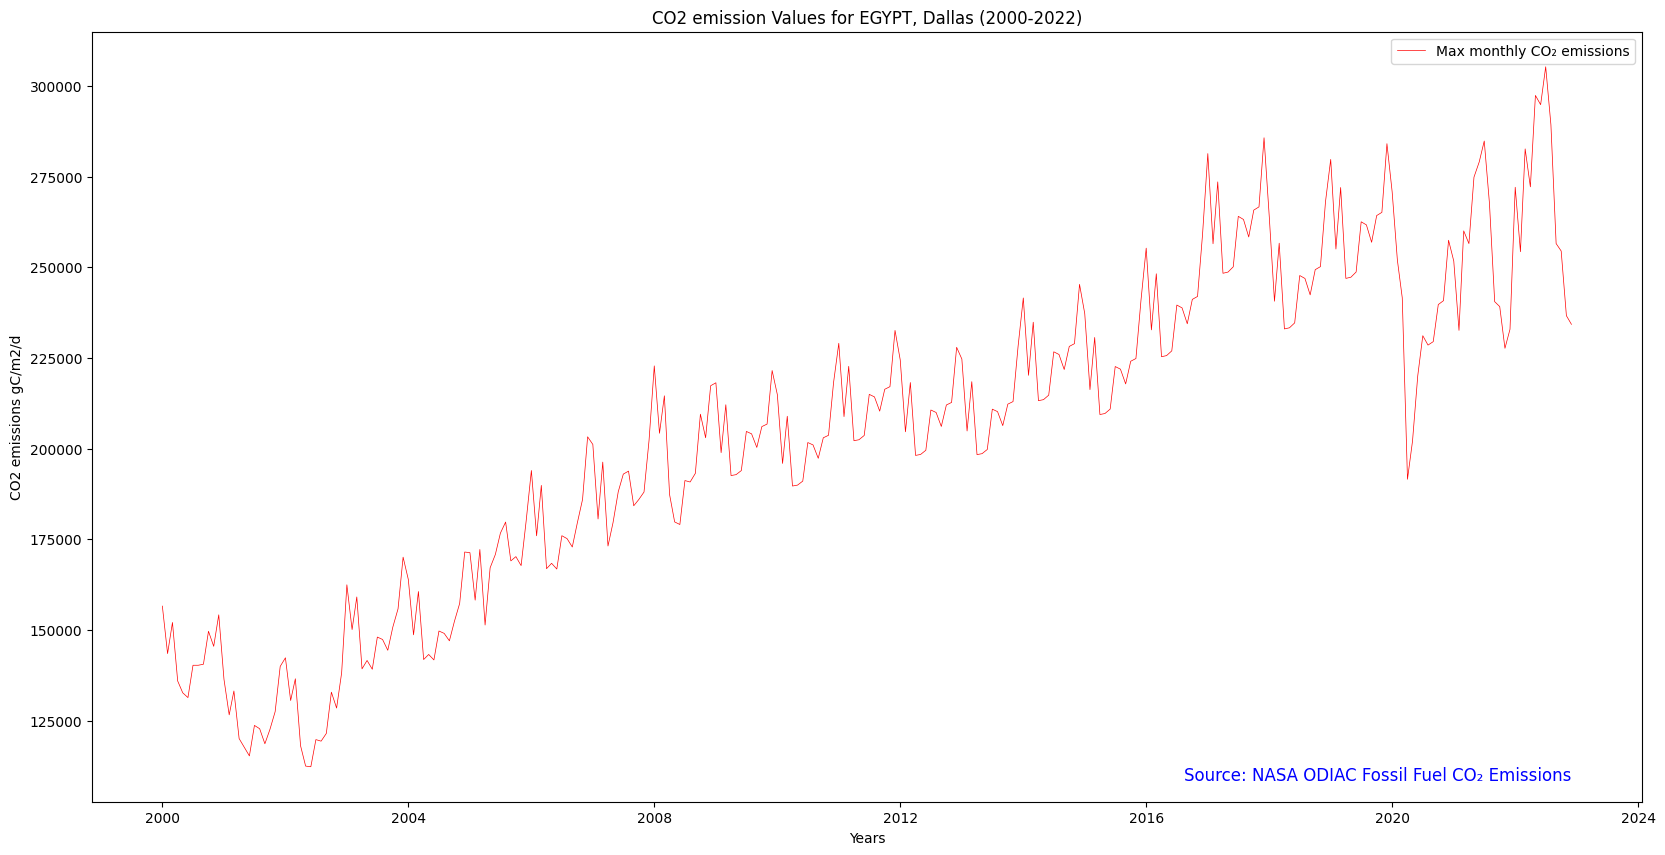

In [173]:
fig = plt.figure(figsize=(20, 10))


plt.plot(
    df["date"],
    df["max"], 
    color="red", 
    linestyle="-", 
    linewidth=0.5, 
    label="Max monthly CO₂ emissions",
)
plt.legend()
plt.xlabel("Years")
plt.ylabel("CO2 emissions gC/m2/d")
plt.title("CO2 emission Values for EGYPT, Dallas (2000-2022)")

plt.text(
    df["date"].iloc[0],          
    df["max"].min(),              

    "Source: NASA ODIAC Fossil Fuel CO₂ Emissions",                  
    fontsize=12,                             
    horizontalalignment="right",            
    verticalalignment="top",                
    color="blue",                           
)
plt.show()

In [174]:
import pandas as pd

# Perform one-hot encoding on the 'start_datetime' column
df_encoded_fixed = pd.get_dummies(df, columns=['start_datetime'])

# Inspect the data types of the dataframe to identify non-boolean columns
print(df_encoded_fixed.dtypes)

# Convert only boolean columns (True/False) to integers (1/0)
boolean_columns = df_encoded_fixed.select_dtypes(include=['bool']).columns
df_encoded_fixed[boolean_columns] = df_encoded_fixed[boolean_columns].astype(int)

# Display the result
df_encoded_fixed


min                       float64
max                       float64
mean                      float64
count                     float64
sum                       float64
                           ...   
start_datetime_2022-08       bool
start_datetime_2022-09       bool
start_datetime_2022-10       bool
start_datetime_2022-11       bool
start_datetime_2022-12       bool
Length: 293, dtype: object


,min,max,mean,count,sum,std,median,majority,minority,unique,...,start_datetime_2022-03,start_datetime_2022-04,start_datetime_2022-05,start_datetime_2022-06,start_datetime_2022-07,start_datetime_2022-08,start_datetime_2022-09,start_datetime_2022-10,start_datetime_2022-11,start_datetime_2022-12
0,1.286377,234270.578125,33.095154,124797.0,4130176.00,863.681075,8.821596,2.289794,1.286377,106789.0,...,0,0,0,0,0,0,0,0,0,1
1,1.294872,236652.265625,33.302094,124797.0,4156001.25,872.447276,8.870621,2.302310,1.294872,106790.0,...,0,0,0,0,0,0,0,0,1,0
2,1.388108,254496.046875,35.688816,124797.0,4453857.00,938.216826,9.499681,2.465578,1.388108,106793.0,...,0,0,0,0,0,0,0,1,0,0
3,1.394934,256545.843750,35.853199,124797.0,4474371.50,945.759847,9.538562,2.475209,1.394934,106796.0,...,0,0,0,0,0,0,1,0,0,0
4,1.563245,289315.343750,40.153980,124797.0,5011096.50,1066.534575,10.669247,2.768200,1.563245,106798.0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,4.393573,132653.656250,22.756031,103271.0,2350038.00,537.953733,8.884389,39.370945,4.393573,101447.0,...,0,0,0,0,0,0,0,0,0,0
272,4.439320,135915.703125,23.092676,103271.0,2384803.75,551.145540,8.965074,50.415916,4.439320,101497.0,...,0,0,0,0,0,0,0,0,0,0
273,4.704121,152058.687500,25.509733,103271.0,2634415.75,616.555249,9.823283,47.027130,4.704121,101670.0,...,0,0,0,0,0,0,0,0,0,0
274,4.400630,143465.109375,24.039633,103271.0,2482597.00,581.705816,9.251390,41.930737,4.400630,101573.0,...,0,0,0,0,0,0,0,0,0,0


In [175]:
print(df_encoded_fixed.columns)


Index(['min', 'max', 'mean', 'count', 'sum', 'std', 'median', 'majority',
       'minority', 'unique',
       ...
       'start_datetime_2022-03', 'start_datetime_2022-04',
       'start_datetime_2022-05', 'start_datetime_2022-06',
       'start_datetime_2022-07', 'start_datetime_2022-08',
       'start_datetime_2022-09', 'start_datetime_2022-10',
       'start_datetime_2022-11', 'start_datetime_2022-12'],
      dtype='object', length=293)


In [178]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Drop 'max' column from features if it exists
X = df_encoded_fixed.drop(columns=['max'], errors='ignore')  # Dropping 'max' from features

# Select only numeric columns for features
X = X.select_dtypes(include=[np.number])  # Ensure only numeric data is selected
y = df_encoded_fixed['max']  # Assuming 'max' is the target column

# Check if there are any problematic data types
print(X.dtypes)

# Initialize scalers
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Scale the features and target separately
X_scaled = scaler_X.fit_transform(X)  # Scale features
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))  # Scale target (reshape required for MinMaxScaler)

# Reshape X for LSTM (samples, timesteps, features)
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_scaled, test_size=0.2, random_state=42)

# Output the shapes to verify
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)



min                       float64
mean                      float64
count                     float64
sum                       float64
std                       float64
                           ...   
start_datetime_2022-08      int32
start_datetime_2022-09      int32
start_datetime_2022-10      int32
start_datetime_2022-11      int32
start_datetime_2022-12      int32
Length: 290, dtype: object
X_train shape: (220, 1, 290)
X_test shape: (56, 1, 290)
y_train shape: (220, 1)
y_test shape: (56, 1)


In [179]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Define the LSTM model
model = Sequential()

# Add the LSTM layer (input shape: timesteps=1, features=X_train.shape[2])
model.add(LSTM(50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))

# Add the output layer (Dense layer with one output neuron for regression)
model.add(Dense(1))

# Compile the model (using mean squared error loss for regression)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Print the model summary
model.summary()


# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)



c:\Users\zahra\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_23 (LSTM)                  │ (None, 50)             │        68,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,251 (266.61 KB)

 Trainable params: 68,251 (266.61 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - loss: 0.3021 - val_loss: 0.2007
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1614 - val_loss: 0.0991
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0703 - val_loss: 0.0392
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0305 - val_loss: 0.0141
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0137 - val_loss: 0.0086
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0099 - val_loss: 0.0063
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0071 - val_loss: 0.0045
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0043 - val_loss: 0.0050
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0036 - val_loss: 0.0058
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0035 - val_loss: 0.0056
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0030 - val_loss: 0.0049
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0026 - val_loss: 0.0043


In [180]:
# Evaluate the model on the test data
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

# Make predictions on the test set
y_pred = model.predict(X_test)

# Inverse transform predictions and actual values (if scaled)
y_pred_rescaled = scaler_y.inverse_transform(y_pred)
y_test_rescaled = scaler_y.inverse_transform(y_test)

# Print some sample predictions vs actual values
for i in range(5):
    print(f"Predicted: {y_pred_rescaled[i][0]}, Actual: {y_test_rescaled[i][0]}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0030 
Test Loss: 0.0030863769352436066
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
Predicted: 217712.578125, Actual: 220067.453125
Predicted: 206801.21875, Actual: 209961.64062499997
Predicted: 159759.75, Actual: 175166.1875
Predicted: 222251.765625, Actual: 198388.81249999997
Predicted: 169895.0625, Actual: 171475.125


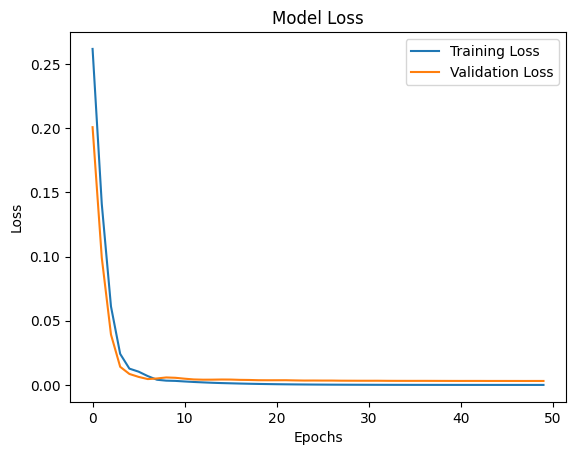

In [181]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()


In [182]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.graph_objs as go
import pandas as pd
import numpy as np

# Assuming you have y_test_rescaled and y_pred_rescaled as your model predictions and actual values
# Example data: Replace with your actual data
epochs = np.arange(1, 101)
train_loss = np.random.rand(100)
val_loss = np.random.rand(100)
y_test_rescaled = np.random.rand(50) * 100
y_pred_rescaled = np.random.rand(50) * 100

# Initialize the Dash app
app = dash.Dash(__name__)

# Define the layout of the dashboard
app.layout = html.Div([
    html.H1("LSTM Model Dashboard"),
    
    # First graph: Training and Validation Loss over Epochs
    dcc.Graph(id='loss-graph'),
    
    # Second graph: Predicted vs Actual values
    dcc.Graph(id='pred-actual-graph'),
    
    # Dropdown for selecting the number of epochs (for interactivity)
    dcc.Slider(
        id='epoch-slider',
        min=1,
        max=100,
        step=1,
        value=50,
        marks={str(epoch): str(epoch) for epoch in range(1, 101, 10)},
    ),
])

# Update the Loss graph based on the number of epochs selected by the slider
@app.callback(
    Output('loss-graph', 'figure'),
    [Input('epoch-slider', 'value')]
)
def update_loss_graph(selected_epoch):
    # Slice the loss data based on selected epoch
    trace1 = go.Scatter(x=epochs[:selected_epoch], y=train_loss[:selected_epoch], mode='lines', name='Train Loss')
    trace2 = go.Scatter(x=epochs[:selected_epoch], y=val_loss[:selected_epoch], mode='lines', name='Validation Loss')
    
    return {
        'data': [trace1, trace2],
        'layout': go.Layout(title='Training and Validation Loss',
                            xaxis={'title': 'Epochs'},
                            yaxis={'title': 'Loss'})
    }

# Update the Predictions vs Actual graph
@app.callback(
    Output('pred-actual-graph', 'figure'),
    [Input('epoch-slider', 'value')]
)
def update_pred_actual_graph(selected_epoch):
    # This graph doesn't depend on epoch, but you could add interactivity here if needed
    trace1 = go.Scatter(x=y_test_rescaled, y=y_pred_rescaled, mode='markers', name='Predictions vs Actual')
    
    return {
        'data': [trace1],
        'layout': go.Layout(title='Predictions vs Actual',
                            xaxis={'title': 'Actual Values'},
                            yaxis={'title': 'Predicted Values'},
                            showlegend=True)
    }

if __name__ == '__main__':
    app.run_server(debug=True, port=8056)  # Specify a different port, e.g., 8051

